Documentation: https://docs.google.com/document/d/15bJbYTocLbz-RuyO0Nf8XZ9bXN596xQYVdtvhlPhnag/edit

This version allows to manage a number N of stocks (it is given as input) rather than only 1 stock.

First of all, we have to load our data so we create a function to do so. We are going to get it from YahooFinance.

In [1]:
#!pip install yfinance
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
from pandas_datareader import data as pdr

def load_data(stocks, start_date, end_date = []):
    df_data = pd.DataFrame()
    for stock_name in stocks:
        yf.pdr_override()

        # Start date:
        start_year, start_month, start_day = start_date
        start = dt.datetime(start_year,start_month,start_day)

        # End date
        if end_date: 
            end_year, end_month, end_day = end_date
            end = dt.datetime(end_year,end_month,end_day)
        else: # If no data is passed to end_date, we assume it is now 
            end = dt.datetime.now()

        df=pdr.get_data_yahoo(stock_name,start,end)

        # To change index from date to num:
        df = df.reset_index()
        
        # Drop the colums we are not going to use:
        df = df.drop("High",axis=1)
        df = df.drop("Low",axis=1)
        df = df.drop("Volume",axis=1)
        df = df.drop("Close",axis=1) # We don't use the Close Price 
        df = df.drop("Adj Close",axis=1) # Nor do we use the Adj Close Price 
        
        df = df.rename(columns={"Open":f"{stock_name} Open"})
        
        if not df_data.columns.to_list():
            df_data = df
        else:
            df_data = pd.merge(df_data, df, on="Date")
        
    
    return df_data
    
load_data(["AAPL","AMZN","TSLA"],[2018,1,1]).head() # Example

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,AAPL Open,AMZN Open,TSLA Open
0,2018-01-02,42.540001,58.599998,20.799999
1,2018-01-03,43.132500,59.415001,21.400000
2,2018-01-04,43.134998,60.250000,20.858000
3,2018-01-05,43.360001,60.875500,21.108000
4,2018-01-08,43.587502,61.799999,21.066668


Now, we are going to generate a sample data for the predictions in the selected time range:

#### In the 3rd approach, this function changes. Now, instead of returing a df with 3 options for a stock and the strength, it now returns a df with two columns per stock. The first column for each stock is the number of shares to buy/sell in this way: if positive buy, if 0 hold and if negative sell. The second column is the strength of the prediction for each stock.

In [2]:
import random

def sample_predictions_array(data, stocks, strength_100 = False):
    sample_predictions_df = pd.DataFrame(columns=["Date"])
    index = 0

    
    for value in data.iterrows():
        sample_predictions_df.loc[index] = 0
        
        for stock in stocks:
    
            date = value[1][0].strftime('%Y-%m-%d')    
                        
            num_buy = random.randint(1,10)
            num_sell = random.randint(1,10)

            rand_num = random.uniform(0,1)
            strength = random.randint(50,100)
            

            if strength_100:
                if 0 < rand_num < 1/3:
                    sample_predictions_df.loc[index,["Date",f"{stock} Prediction",f"{stock} Strength"]] = [date,num_buy,100]
                elif 1/3 < rand_num < 2/3:
                    sample_predictions_df.loc[index,["Date",f"{stock} Prediction",f"{stock} Strength"]] = [date,0,100]
                elif 2/3 < rand_num < 1:
                    sample_predictions_df.loc[index,["Date",f"{stock} Prediction",f"{stock} Strength"]] = [date,-num_sell,100]
            else:
                if 0 < rand_num < 1/3:
                    sample_predictions_df.loc[index,["Date",f"{stock} Prediction",f"{stock} Strength"]] = [date,num_buy,strength]
                elif 1/3 < rand_num < 2/3:
                    sample_predictions_df.loc[index,["Date",f"{stock} Prediction",f"{stock} Strength"]] = [date,0,0]
                elif 2/3 < rand_num < 1:
                    sample_predictions_df.loc[index,["Date",f"{stock} Prediction",f"{stock} Strength"]] = [date,-num_sell,strength]
        
        index += 1
            
            
            
    return sample_predictions_df

stocks = ["AAPL","AMZN","TSLA"]
sample_predictions_array(load_data(stocks,[2022,1,1]),stocks).head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,AAPL Prediction,AAPL Strength,AMZN Prediction,AMZN Strength,TSLA Prediction,TSLA Strength
0,2022-01-03,9.0,53.0,7.0,83.0,0.0,0.0
1,2022-01-04,-6.0,95.0,-3.0,66.0,8.0,54.0
2,2022-01-05,-6.0,54.0,-3.0,57.0,0.0,0.0
3,2022-01-06,0.0,0.0,1.0,69.0,0.0,0.0
4,2022-01-07,6.0,81.0,3.0,96.0,-7.0,52.0


We create a function to get the total amount of money that we owe to the bank:

In [3]:
def total_money_owed(money_owed_dict):
    total_sum = 0
    for borrowing_index in money_owed_dict.keys():
        total_sum += money_owed_dict[borrowing_index]["Money owed"]
    return total_sum

example = {1: {'Money owed': 5}, 4: {'Money owed': 10}}
example[9] = {'Money owed' : 14}
total_money_owed(example)

29

We create a function that returns the money that needs to be returned given an initial borrowed money and the date that it was borrowed:

In [4]:
from math import exp
def update_owed_money(borrowing_index,borrowed_money,index,interest_rate):
    # We use the indexes instead of the dates to calculate the difference in trading days because it is different from the number in natural days:
    days = index - borrowing_index 
    return borrowed_money * exp(interest_rate * days / 252)


print(update_owed_money(1,100,253,0.0487))
print(exp(0.0487)*100)

104.99053318899962
104.99053318899962


We are going to create various plots to see if it is better selling the biggest amount of money rather than the money that was borrowed first:

Now we create our backtesting strategy:

In [5]:
borrowing_strength_threshold = 75

In [6]:
import math

def backtest(stocks, initial_capital, interest_rate, predictions_array, start_date, end_date = []):

    # Load the Yahoo Finance data for the time range:
    data = load_data(stocks, start_date, end_date)
    
    # We need to do this to format correctly the dates:
    data["Date"] = pd.to_datetime(data["Date"])
    predictions_array["Date"] = pd.to_datetime(predictions_array["Date"])

    # The first thing we do is merge both dfs into one to make it more accessible:
    prices_and_predictions = pd.merge(data, predictions_array, on="Date")

    
    # Create the df and the columns we are going to use:
    complete_df = pd.DataFrame()
    complete_df["Date"] = predictions_array["Date"]
    for stock in stocks:
        prices_and_predictions[f"{stock} Tom's - Tod's open ($)"] = 0
        complete_df[f"{stock} Open"] = prices_and_predictions[f"{stock} Open"]
        complete_df[f"{stock} Pred num"] = predictions_array[f"{stock} Prediction"]
        complete_df[f"{stock} Nº of shares"] = 0
    complete_df["Total Nº of shares"] = 0
    complete_df["Daily interest ($)"] = 0
    complete_df["Total interest ($)"] = 0
    complete_df["Total money owed ($)"] = 0
    complete_df["Invested money ($)"] = 0
    complete_df["Tomorrow's Available money ($)"] = 0
    complete_df["Daily profit ($)"] = 0
    complete_df["Net profit ($)"] = 0
    complete_df["Capital ($)"] = 0
    
    
    daily_profit = 0
    money_owed_dict = {}
    
    # Backtest:
    for value in prices_and_predictions.iterrows(): # Each day
        index = value[0]
        date = value[1]["Date"]
        
        
        # We do this here so the money isn't updated for every stock:
        daily_interest = 0

        if money_owed_dict: # If we own any money

            # The first thing we do each day is update the money we owe:
            for borrowing_index in money_owed_dict.keys():
                # Firstly we compute the daily interest generated:
                daily_interest += (update_owed_money(borrowing_index,money_owed_dict[borrowing_index]["Borrowed money"],index,interest_rate) - money_owed_dict[borrowing_index]["Money owed"])
                # Daily interest could be computed as well using the total_money_owed (it is the same)

                # Now we update the money that we owe and leave the borrowed money as it is:
                money_owed_dict[borrowing_index]["Money owed"] = update_owed_money(borrowing_index,money_owed_dict[borrowing_index]["Borrowed money"],index,interest_rate)

            # We update the column in complete_df of the money owed by the daily interet generated:
            complete_df.loc[index,"Total money owed ($)"] = total_money_owed(money_owed_dict)

        #print(date)
        #print(money_owed_dict)
        # Now we add the daily interest to the complete_df columns:
        if index > 0:
            complete_df.loc[index,"Daily interest ($)"] = daily_interest
            complete_df.loc[index,"Total interest ($)"] = complete_df.loc[index-1,"Total interest ($)"] + daily_interest
            
        
        # We create a new list of stocks that has first the stocks we are going to sell and then the stocks we are going to buy
        # This improves the Engine because it allows to borrow less money if that day we are going to sell some stocks and then buy others
        sell_stocks = [stock for stock in stocks if value[1][f"{stock} Prediction"] < 0] 
        buy_stocks = [stock for stock in stocks if value[1][f"{stock} Prediction"] >= 0]
        
        # We sort here the buy_stocks list in descending order of strength so we give more importance to buy predictions with higher strength:
        buy_stocks_dict = {}
        for stock in buy_stocks:
            buy_stocks_dict[stock] = value[1][f"{stock} Strength"]
        buy_stocks_sorted = sorted(buy_stocks_dict, key=buy_stocks_dict.get, reverse=True)

        new_stocks = sell_stocks + buy_stocks_sorted


        for stock in new_stocks: # For each stock
            
            if index < (complete_df.shape[0]-1):
                complete_df.loc[index,f"{stock} Tom's - Tod's open ($)"] = prices_and_predictions.loc[index+1,f"{stock} Open"] - prices_and_predictions.loc[index,f"{stock} Open"]
            
            # The variables we need to use:
            open_price = value[1][f"{stock} Open"]
            pred = np.sign(value[1][f"{stock} Prediction"])
            num_buy = value[1][f"{stock} Prediction"]
            num_sell = abs(value[1][f"{stock} Prediction"]) 
            strength = value[1][f"{stock} Strength"]


            if index < (complete_df.shape[0]-1): # Because of how we have constructed our engine, the last day doesn't matter:

                if index == 0: # The first day:
                    if stock == new_stocks[0]: # If it is the first stock of the list:
                        if pred > 0:
                            if initial_capital > num_buy*open_price:
                                complete_df.loc[index,f"{stock} Nº of shares"] = num_buy
                                complete_df.loc[index,"Total Nº of shares"] =  num_buy
                                complete_df.loc[index,"Invested money ($)"] = num_buy*open_price
                                complete_df.loc[index,"Tomorrow's Available money ($)"] = initial_capital - num_buy*open_price
                            else:
                                if strength > borrowing_strength_threshold: # If we don't have enough money but it is a strong buy, we borrow money from the bank:
                                    needed_money = num_buy*open_price - initial_capital
                                    complete_df.loc[index,"Total money owed ($)"] = needed_money
                                    money_owed_dict[index] = {'Money owed': needed_money, 'Borrowed money': needed_money}
                                    complete_df.loc[index,f"{stock} Nº of shares"] = num_buy
                                    complete_df.loc[index,"Total Nº of shares"] = num_buy
                                    complete_df.loc[index,"Invested money ($)"] = num_buy*open_price
                                    complete_df.loc[index,"Tomorrow's Available money ($)"] = 0

                                else: # If we don't have enough money and it is not a strong buy, we buy as many shares as we can:
                                    num = math.floor(initial_capital/open_price)
                                    complete_df.loc[index,f"{stock} Nº of shares"] = num
                                    complete_df.loc[index,"Total Nº of shares"] = num
                                    complete_df.loc[index,"Invested money ($)"] = num*open_price
                                    complete_df.loc[index,"Tomorrow's Available money ($)"] = initial_capital - num*open_price

                        elif pred == 0: # If pred == 0 is hold
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = initial_capital

                        elif pred < 0: # If pred < 0 is sell
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = initial_capital   
                            
                    else: # If it is not the first stock:
                        if pred  > 0: # If pred > 0 is buy
                            # If we have enough money to buy all of them:
                            if complete_df.loc[index,"Tomorrow's Available money ($)"] > num_buy*open_price:
                                complete_df.loc[index,f"{stock} Nº of shares"] = num_buy
                                complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index,"Total Nº of shares"] + num_buy
                                complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index,"Invested money ($)"] + num_buy*open_price
                                complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index,"Tomorrow's Available money ($)"] - num_buy*open_price
                            else:
                                if strength > borrowing_strength_threshold: # If we don't have enough money but it is a strong buy, we borrow money from the bank:
                                    if complete_df.loc[index,"Total money owed ($)"]:
                                        needed_money = num_buy*open_price # If we have already borrowed money, we have no money left
                                    else:
                                        needed_money = num_buy*open_price - initial_capital
                                    complete_df.loc[index,"Total money owed ($)"] = complete_df.loc[index,"Total money owed ($)"] + needed_money
                                    if index in money_owed_dict.keys(): # If we have already borrowed money that day
                                        money_owed_dict[index] = {'Money owed': needed_money + money_owed_dict[index]["Money owed"], 'Borrowed money': needed_money + money_owed_dict[index]["Borrowed money"]}
                                    else:
                                        money_owed_dict[index] = {'Money owed': needed_money, 'Borrowed money': needed_money}
                                    complete_df.loc[index,f"{stock} Nº of shares"] = num_buy
                                    complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index,"Total Nº of shares"] + num_buy
                                    complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index,"Invested money ($)"] + num_buy*open_price
                                    complete_df.loc[index,"Tomorrow's Available money ($)"] = 0 # If we hadn't enough money, tomorrow's available is 0$

                                else: # If we don't have enough money and it is not a strong buy, we buy as many shares as we can:
                                    num = math.floor(complete_df.loc[index,"Tomorrow's Available money ($)"]/open_price)
                                    complete_df.loc[index,f"{stock} Nº of shares"] = num
                                    complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index,"Total Nº of shares"] + num
                                    complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index,"Invested money ($)"] + num*open_price
                                    complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index,"Tomorrow's Available money ($)"] - num*open_price
                                    
                        elif pred == 0: # If pred == 0 is hold
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index,"Tomorrow's Available money ($)"]

                        elif pred < 0: # If pred < 0 is sell
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index,"Tomorrow's Available money ($)"]

                elif index > 0: # The rest of the days:
                    if stock == new_stocks[0]: # If it is the first stock of the list:
                        if pred > 0:
                            # We check if we have enough money to buy all the shares that we have to:
                            if complete_df.loc[index-1,"Tomorrow's Available money ($)"] > num_buy*open_price:
                                complete_df.loc[index,f"{stock} Nº of shares"] = complete_df.loc[index-1,f"{stock} Nº of shares"] + num_buy
                                complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index-1,"Total Nº of shares"] + num_buy
                                complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"] + num_buy*open_price
                                complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"] - num_buy*open_price
                            else:
                                if strength > 75: # If we don't have enough money but it is a strong buy, we borrow money from the bank:
                                    needed_money = num_buy*open_price - complete_df.loc[index-1,"Tomorrow's Available money ($)"]
                                    complete_df.loc[index,"Total money owed ($)"] = complete_df.loc[index,"Total money owed ($)"] + needed_money
                                    money_owed_dict[index] = {'Money owed': needed_money, 'Borrowed money': needed_money}
                                    complete_df.loc[index,f"{stock} Nº of shares"] = complete_df.loc[index-1,f"{stock} Nº of shares"] + num_buy
                                    complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index-1,"Total Nº of shares"] + num_buy
                                    complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"] + num_buy*open_price
                                    complete_df.loc[index,"Tomorrow's Available money ($)"] = 0

                                else: # If we don't have enough money and it is not a strong buy, we buy as many shares as we can:
                                    num = math.floor(complete_df.loc[index-1,"Tomorrow's Available money ($)"]/open_price)
                                    complete_df.loc[index,f"{stock} Nº of shares"] = complete_df.loc[index-1,f"{stock} Nº of shares"] + num
                                    complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index-1,"Total Nº of shares"] + num
                                    complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"] + num*open_price
                                    complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"] - num*open_price

                        elif pred == 0:
                            complete_df.loc[index,f"{stock} Nº of shares"] = complete_df.loc[index-1,f"{stock} Nº of shares"]
                            complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index-1,"Total Nº of shares"]
                            complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"]
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"]

                        elif pred < 0:
                            if complete_df.loc[index-1,f"{stock} Nº of shares"] > 0: # We check if we have stocks to sell (we don't accept short-selling):
                                
                                if num_sell < complete_df.loc[index-1,f"{stock} Nº of shares"]: # If we have more stocks than we have to sell:
                                    complete_df.loc[index,f"{stock} Nº of shares"] = complete_df.loc[index-1,f"{stock} Nº of shares"] - num_sell
                                    complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index-1,"Total Nº of shares"] - num_sell
                                    complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"] - num_sell*open_price
                                    complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"] + num_sell*open_price

                                else: # If we have less stocks than we have to sell we just sell all of them:
                                    complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"] + complete_df.loc[index-1,f"{stock} Nº of shares"]*open_price
                                    complete_df.loc[index,f"{stock} Nº of shares"] = 0
                                    complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index-1,"Total Nº of shares"] - complete_df.loc[index-1,f"{stock} Nº of shares"]
                                    complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"] - complete_df.loc[index-1,f"{stock} Nº of shares"]*open_price 

                            else: # If have no stocks to sell we have to update these (stock Nº is 0 so we don't need to update it):
                                complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"]
                                complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index-1,"Total Nº of shares"]
                                complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"]


                    else: # If it is not the first stock in the list:
                        
                        if pred > 0:
                            # We check if we have enough money to buy all the shares that we have to:
                            if complete_df.loc[index,"Tomorrow's Available money ($)"] > num_buy*open_price:
                                complete_df.loc[index,f"{stock} Nº of shares"] = complete_df.loc[index-1,f"{stock} Nº of shares"] + num_buy
                                complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index,"Total Nº of shares"] + num_buy
                                complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index,"Invested money ($)"] + num_buy*open_price
                                complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index,"Tomorrow's Available money ($)"] - num_buy*open_price
                            else:
                                if strength > 75: # If we don't have enough money but it is a strong buy, we borrow money from the bank:
                                    needed_money = num_buy*open_price - complete_df.loc[index,"Tomorrow's Available money ($)"]
                                    complete_df.loc[index,"Total money owed ($)"] = complete_df.loc[index,"Total money owed ($)"] + needed_money
                                    if index in money_owed_dict.keys(): # If we have already borrowed money that day
                                        money_owed_dict[index] = {'Money owed': needed_money + money_owed_dict[index]["Money owed"], 'Borrowed money': needed_money + money_owed_dict[index]["Borrowed money"]}
                                    else:
                                        money_owed_dict[index] = {'Money owed': needed_money, 'Borrowed money': needed_money}
                                    complete_df.loc[index,f"{stock} Nº of shares"] = complete_df.loc[index-1,f"{stock} Nº of shares"] + num_buy
                                    complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index,"Total Nº of shares"] + num_buy
                                    complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index,"Invested money ($)"] + num_buy*open_price
                                    complete_df.loc[index,"Tomorrow's Available money ($)"] = 0

                                else: # If we don't have enough money and it is not a strong buy, we buy as many shares as we can:
                                    num = math.floor(complete_df.loc[index,"Tomorrow's Available money ($)"]/open_price)
                                    complete_df.loc[index,f"{stock} Nº of shares"] = complete_df.loc[index-1,f"{stock} Nº of shares"] + num
                                    complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index,"Total Nº of shares"] + num
                                    complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index,"Invested money ($)"] + num*open_price
                                    complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index,"Tomorrow's Available money ($)"] - num*open_price

                        elif pred == 0:
                            complete_df.loc[index,f"{stock} Nº of shares"] = complete_df.loc[index-1,f"{stock} Nº of shares"]
                            complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index,"Total Nº of shares"]
                            complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index,"Invested money ($)"]
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index,"Tomorrow's Available money ($)"]

                        elif pred < 0:
                            if complete_df.loc[index-1,f"{stock} Nº of shares"] > 0: # We check if we have stocks to sell (we don't accept short-selling):

                                if num_sell < complete_df.loc[index-1,f"{stock} Nº of shares"]: # If we have more stocks than we have to sell:
                                    complete_df.loc[index,f"{stock} Nº of shares"] = complete_df.loc[index-1,f"{stock} Nº of shares"] - num_sell
                                    complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index,"Total Nº of shares"] - num_sell
                                    complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index,"Invested money ($)"] - num_sell*open_price
                                    complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index,"Tomorrow's Available money ($)"] + num_sell*open_price

                                else: # If we have less stocks than we have to sell we just sell all of them:
                                    complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index,"Tomorrow's Available money ($)"] + complete_df.loc[index-1,f"{stock} Nº of shares"]*open_price
                                    complete_df.loc[index,f"{stock} Nº of shares"] = 0
                                    complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index,"Total Nº of shares"] - complete_df.loc[index-1,f"{stock} Nº of shares"]                                
                                    complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index,"Invested money ($)"] - complete_df.loc[index-1,f"{stock} Nº of shares"]*open_price # Set invested money to 0 if we run out of stocks, check the documentation

                            else: # If we don't have stocks to sell, we do nothing here:
                                pass
                                
                                          
                    # Now that we may have enough money to return to the bank part of the money that we owe, we try to do it:
                    if money_owed_dict:
                        # This first step is to check how much money we can return to the bank:
                        borrowing_indexes_to_return = [] # The days from which we can return the borrowed money:
                        money_return_aux = 0 # An auxiliar variable to check how much money we can return
                        for borrowing_index in money_owed_dict.keys():
                            if borrowing_index != index: # We don't return the money that we borrow the same day (this is a choice, we could do it)
                                # This adds the money of each day in chronological order:
                                if (money_return_aux + money_owed_dict[borrowing_index]["Money owed"]) < complete_df.loc[index,"Tomorrow's Available money ($)"]:
                                    money_return_aux += money_owed_dict[borrowing_index]["Money owed"]
                                    borrowing_indexes_to_return.append(borrowing_index)

                        
                        # We need to create this copy in the 3rd approach in order for the engine to work when we can return
                        # more than 2 indexes on a day
                        borrowing_indexes_to_return_copy = [*borrowing_indexes_to_return]
                        
                            
                        # Now that we know what Nº of money we can return and to which days it corresponds, we return it:
                        for return_index in borrowing_indexes_to_return_copy:

                            # We substract the money owed from tomorrow's available money:
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index,"Tomorrow's Available money ($)"] - money_owed_dict[return_index]["Money owed"] 
                            # We substract "Money owed" and not "Borrowed money" because Tomorrow's available money hasn't been updated by the daily_interest

                            # We update the column in complete_df
                            complete_df.loc[index,"Total money owed ($)"] = complete_df.loc[index,"Total money owed ($)"] - money_owed_dict[return_index]["Money owed"] 

                            # Remove the index from the list of returning indexes and from the money owed dict:
                            del money_owed_dict[return_index]
                            borrowing_indexes_to_return.remove(return_index)


            # Compute the different metrics:

            if index == 0: # The first day
                prices_and_predictions.loc[index,f"{stock} Tom's - Tod's open ($)"] = prices_and_predictions.loc[index+1,f"{stock} Open"] - prices_and_predictions.loc[index,f"{stock} Open"]
                complete_df.loc[index,"Daily profit ($)"] = complete_df.loc[index,"Daily profit ($)"] + prices_and_predictions.loc[index,f"{stock} Tom's - Tod's open ($)"]*complete_df.loc[index,f"{stock} Nº of shares"]
                complete_df.loc[index,"Net profit ($)"] = complete_df.loc[index,"Daily profit ($)"]

            elif index < (complete_df.shape[0]-1): # All the days except the first and the last one
                prices_and_predictions.loc[index,f"{stock} Tom's - Tod's open ($)"] = prices_and_predictions.loc[index+1,f"{stock} Open"] - prices_and_predictions.loc[index,f"{stock} Open"]
                complete_df.loc[index,"Daily profit ($)"] = complete_df.loc[index,"Daily profit ($)"] + prices_and_predictions.loc[index,f"{stock} Tom's - Tod's open ($)"]*complete_df.loc[index,f"{stock} Nº of shares"]
                if stock == new_stocks[0]:
                    complete_df.loc[index,"Net profit ($)"] = complete_df.loc[index-1,"Net profit ($)"] + prices_and_predictions.loc[index,f"{stock} Tom's - Tod's open ($)"]*complete_df.loc[index,f"{stock} Nº of shares"]
                else:
                    complete_df.loc[index,"Net profit ($)"] = complete_df.loc[index,"Net profit ($)"] + prices_and_predictions.loc[index,f"{stock} Tom's - Tod's open ($)"]*complete_df.loc[index,f"{stock} Nº of shares"]
                    
            else: # The last day
                complete_df.loc[index,"Net profit ($)"] = complete_df.loc[index-1,"Net profit ($)"]
                complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"]
                complete_df.loc[index,f"{stock} Nº of shares"] = complete_df.loc[index-1,f"{stock} Nº of shares"]
                complete_df.loc[index,"Total Nº of shares"] = complete_df.loc[index-1,"Total Nº of shares"]
                complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"]

                # What we set to NaN because doesn't appear on the last day:
                complete_df.loc[index,f"{stock} Pred num"] = np.nan 
                prices_and_predictions.loc[index,f"{stock} Tom's - Tod's open ($)"] = np.nan
                


        # We need to update the invested money by the daily profit of that day (before updating it by the daily interest):
        if index < (complete_df.shape[0]-1):
            complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index,"Invested money ($)"] + complete_df.loc[index,"Daily profit ($)"]

        # We compute here the capital:
        complete_df.loc[index,"Capital ($)"] = complete_df.loc[index,"Invested money ($)"] + complete_df.loc[index,"Tomorrow's Available money ($)"] - complete_df.loc[index,"Total money owed ($)"]
        # Here, "Total money owed" is the only variable that is updated by the daily interest, what indeed it is what makes sense, hence the capital is also affected by the daily interest

        # We substract here the daily interest generated from Daily profit & Net profit:
        complete_df.loc[index,"Daily profit ($)"] = complete_df.loc[index,"Daily profit ($)"] - daily_interest
        complete_df.loc[index,"Net profit ($)"] = complete_df.loc[index,"Net profit ($)"] - daily_interest
    
        if index == (complete_df.shape[0]-1):
            complete_df.loc[index,"Daily profit ($)"] = -daily_interest

        # Some security measures to see if everything is okay:

        if abs(complete_df.loc[index,"Net profit ($)"] - (complete_df.loc[index,"Capital ($)"] - initial_capital)) > 0.1:
            # This is a good security measure as these two cuantities are computed differently but should follow this relation: Net profit = Capital - Initial Capital
            print("Problem",date)

        if complete_df.loc[index,"Tomorrow's Available money ($)"] < 0:
            print("Negative available money:",date)        

        if complete_df.loc[index,"Invested money ($)"] < 0:
            print("Something failed")
            print(date)
            

    # We round these columns to have them cleaner and we do it here so the precision in the decimals doesn't affect the results:
    complete_df["Daily profit ($)"] = round(complete_df["Daily profit ($)"],3)
    complete_df["Invested money ($)"] = round(complete_df["Invested money ($)"],3)
    complete_df["Net profit ($)"] = round(complete_df["Net profit ($)"],3)
    complete_df["Capital ($)"] = round(complete_df["Capital ($)"],3)
    complete_df["Tomorrow's Available money ($)"] = round(complete_df["Tomorrow's Available money ($)"],3)
    complete_df["Total money owed ($)"] = round(complete_df["Total money owed ($)"],3)
    complete_df["Total interest ($)"] = round(complete_df["Total interest ($)"],3)
    complete_df["Daily interest ($)"] = round(complete_df["Daily interest ($)"],3)
    for stock in new_stocks:
        complete_df[f"{stock} Tom's - Tod's open ($)"] = round(complete_df[f"{stock} Tom's - Tod's open ($)"],3)

    print(f"\nNet profit in the selected period: {complete_df.loc[index,'Net profit ($)']}$")   

    return complete_df


The logic used for the daily profit is that we buy/sell at the start of the day, so the daily profit is computed as the amount of shares we have that day multplied by the difference between the open price the next day and the open price for the stock that day. Therefore, selling or buying stocks doesn't affect to our profit but only does it the change in the price of that stock between the open price of that day and the open price of the next day.

In [19]:
stocks = ["AMZN","TSLA"]
initial_capital_sample = 0
interest_rate_sample = 0.0487
start_date_sample = [2018,1,1]
# end_date_sample = [2020,8,1]
end_date_sample = []

# random.seed(29)

data_sample = load_data(stocks, start_date_sample,end_date_sample)
predictions_sample = sample_predictions_array(data_sample,stocks,strength_100=True) 
# Set strength_100 = False if backend provides strength

data = backtest(stocks,initial_capital_sample,interest_rate_sample,predictions_sample,start_date_sample,end_date_sample)
# data.to_excel("data.xlsx")
# predictions_sample.to_excel("predictions.xlsx")
data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Net profit in the selected period: 16615.986$


,Date,AMZN Open,AMZN Pred num,AMZN Nº of shares,TSLA Open,TSLA Pred num,TSLA Nº of shares,Total Nº of shares,Daily interest ($),Total interest ($),Total money owed ($),Invested money ($),Tomorrow's Available money ($),Daily profit ($),Net profit ($),Capital ($),AMZN Tom's - Tod's open ($),TSLA Tom's - Tod's open ($)
0,2018-01-02,58.599998,0.0,0,20.799999,0.0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.815,0.600
1,2018-01-03,59.415001,7.0,7,21.400000,0.0,0,7,0.000,0.000,415.905,421.750,0.000,5.845,5.845,5.845,0.835,-0.542
2,2018-01-04,60.250000,2.0,9,20.858000,-7.0,0,9,0.080,0.080,536.485,547.879,0.000,5.549,11.394,11.394,0.625,0.250
3,2018-01-05,60.875500,8.0,17,21.108000,0.0,0,17,0.104,0.184,1023.593,1050.600,0.000,15.613,27.007,27.007,0.924,-0.041
4,2018-01-08,61.799999,7.0,24,21.066668,-7.0,0,24,0.198,0.382,1456.391,1508.280,0.000,24.882,51.889,51.889,1.045,1.277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,2024-05-24,181.649994,7.0,112,174.839996,0.0,10,122,0.746,1969.206,5131.397,21916.159,0.000,-177.786,16784.762,16784.762,-1.720,1.560
1610,2024-05-28,179.929993,-9.0,103,176.399994,-9.0,1,104,0.992,1970.198,3441.567,18889.290,1516.149,179.109,16963.871,16963.871,1.770,-2.210
1611,2024-05-29,181.699997,0.0,103,174.190002,0.0,1,104,0.665,1970.863,3442.233,18853.510,1516.149,-36.445,16927.426,16927.426,-0.390,4.390
1612,2024-05-30,181.309998,0.0,103,178.580002,0.0,1,104,0.665,1971.529,3442.898,18543.400,1516.149,-310.775,16616.651,16616.651,-3.010,-0.080


To check if the engine works, we can try to look at the profit + total interest paid with 0$ of initial capital and check if it is equals to the net profit in these two situations: start with enough initial capital to never borrow money and set the interest rate to 0%. This engine meets these requirements.

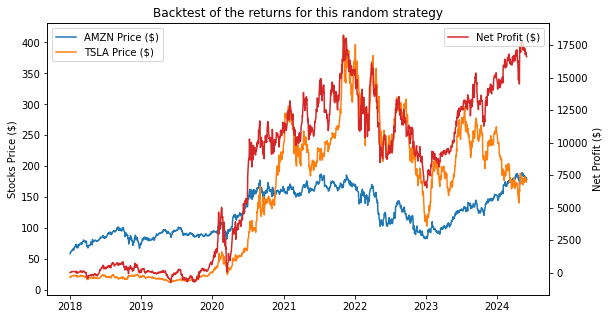

In [20]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(9, 5))
ax1.set_ylabel(f"Stocks Price ($)")
ax1.plot(data["Date"], data[[s + " Open" for s in stocks]], label=[s + " Price ($)" for s in stocks])
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel("Net Profit ($)")
ax2.plot(data["Date"], data["Net profit ($)"], color='tab:red', label="Net Profit ($)")
ax2.legend(loc='upper right')

plt.title("Backtest of the returns for this random strategy")
plt.show()
